<a href="https://colab.research.google.com/github/angelitus2000/TFG_fisica/blob/main/TFG_fisica_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
!pip install pystan
!pip install nest_asyncio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 30.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 MB 31.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 94.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 kB 6.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

import random

from scipy.stats import spearmanr
import scipy.stats as sps

import stan
import nest_asyncio 
nest_asyncio.apply()

# Data gathering

### Necessary data

In [3]:
#Load the necessary dataframes to create the final table
sweetcat = 'https://raw.githubusercontent.com/angelitus2000/TFG_fisica/main/SWEETCAT_Dataframe.csv'
exo = 'https://raw.githubusercontent.com/angelitus2000/TFG_fisica/main/exo.csv'
nasaexo = 'https://raw.githubusercontent.com/angelitus2000/TFG_fisica/main/nasaexo.csv'


sweetcat_df = pd.read_csv(sweetcat)
exo_df = pd.read_csv(exo)
nasaexo_df = pd.read_csv(nasaexo, low_memory=False)

### Stars dataframe

In [4]:
#Select only host stars with homogenous parameters
df = sweetcat_df[sweetcat_df['SWFlag']==1]
df = df.reset_index(drop=True)


#Rename the column that contains the name of stars
df.rename(columns={'Name': 'star_name'}, inplace=True) 


#Select the desired columns
star_columns = ['star_name', 'Teff', 'eTeff', 'Logg', 'eLogg', '[Fe/H]', 
                'e[Fe/H]', 'Mass_t','eMass_t']
df = df[star_columns]

### Exo dataframe

In [5]:
#Select the desired columns
planet_columns = ['name', 'mass', 'mass_error_min', 'mass_error_max',
                  'mass_sini', 'mass_sini_error_min', 'mass_sini_error_max', 
                  'radius', 'radius_error_min', 'radius_error_max', 
                  'semi_major_axis', 'semi_major_axis_error_min', 
                  'semi_major_axis_error_max']
exo_df = exo_df[planet_columns]


#Rename the column that contains the name of planets
exo_df = exo_df.rename(columns={'name': 'planet_name'})


#Obtain a column with the name of th host star for each planet, by deleting the
#last letter and the last space in the name of the planet
exo_df['star_name']  = exo_df['planet_name'].str[:-2]

### Nasa dataframe

In [6]:
#Select the desired columns
nasaplanet_columns = ['pl_name', 'pl_massj', 'pl_massjerr2', 'pl_massjerr1',
                  'pl_msinij', 'pl_msinijerr2', 'pl_msinijerr1', 'pl_radj', 
                  'pl_radjerr2', 'pl_radjerr1', 'pl_orbsmax', 'pl_orbsmaxerr2',
                  'pl_orbsmaxerr1']
nasaexo_df = nasaexo_df[nasaplanet_columns]


#Rename columns so they are named the same as in exo dataframe. Note that minimun 
#errors in this dataframe are named with a 2 and maximum errors with a 1
nasaexo_df.columns = planet_columns
nasaexo_df = nasaexo_df.rename(columns={'name': 'planet_name'})



#In this data frame, lower errors appear with a minus sign. Delete it
nasaexo_df['mass_error_min'] = abs(nasaexo_df['mass_error_min'])
nasaexo_df['mass_sini_error_min'] = abs(nasaexo_df['mass_sini_error_min'])
nasaexo_df['radius_error_min'] = abs(nasaexo_df['radius_error_min'])
nasaexo_df['semi_major_axis_error_min'] = abs(nasaexo_df['semi_major_axis_error_min'])


#Obtain a column with the name of th host star for each planet, by deleting the
#last letter and the last space in the name of the planet
nasaexo_df['star_name']  = nasaexo_df['planet_name'].str[:-2]

### Joining the dataframes

In [7]:
#Join stars dataframe with exo dataframe
df = df.merge(exo_df, on='star_name', how='left')


#Select rows with nan in planet name. Planets for those stars were not found in
#exo dataframe
subset = df[df['planet_name'].isnull()]
indices = subset.index.tolist()


#Delete those rows from the original dataset
df = df[~df.index.isin(indices)]


#Select only columns referred to stars, as the ones referred to planets will be
#obtained from nasa dataset
subset = subset[star_columns]


#Join subset with nasa dataframe
subset = subset.merge(nasaexo_df, on='star_name', how='left')


#Concatenate the subset in the dataframe
df = pd.concat([df, subset]).reset_index(drop=True)


#Delete stars with no planets found in any of the dataframes
df = df[~df['planet_name'].isnull()]

# Data processing

### Planets with no mass data

In [8]:
#Select rows with nan in columns mass and mass_sini. Their masses will be looked
#up in nasa dataframe
subset2 =  df[df['mass'].isnull()]
subset2 = subset2[subset2['mass_sini'].isnull()]
indices2 = subset2.index.tolist()


#Delete those rows from the original dataset
df = df[~df.index.isin(indices2)]


#Select only columns referred to stars and planet name as the rest of the ones
# referred to planets will be obtained from nasa dataset
subset2 = subset2[star_columns+['planet_name']]


#Join subset2 with nasa dataframe
subset2 = subset2.merge(nasaexo_df, on=['star_name','planet_name'], how='left')


#Concatenate subset2 in the dataframe
df = pd.concat([df, subset2]).reset_index(drop=True)


#Delete planets whose mass information was not found in any of the dataframes
subset3 =  df[df['mass'].isnull()]
subset3 = subset3[subset3['mass_sini'].isnull()]
indices3 = subset3.index.tolist()
df = df[~df.index.isin(indices3)]

### Mass cleaning

In [9]:
#Unit conversion from Jupiter to Earth masses
mass_columns = ['mass', 'mass_error_min','mass_error_max', 'mass_sini',
                'mass_sini_error_min', 'mass_sini_error_max']
df[mass_columns] = df[mass_columns]*318



#Flag that takes value 1 if mass if informed and 0 otherwise (only mass_sini)
df['mass_flag'] = np.where(df['mass'].isnull(), 0, 1)


#Create definitive mass columns (mass or mass_sini)
df['mass_def'] = df['mass_flag']*df['mass'].fillna(0)+(1-df['mass_flag'])*df['mass_sini'].fillna(0)

df['mass_def_error_min'] = df['mass_flag']*df['mass_error_min'].fillna(0)+(1-df['mass_flag'])*df['mass_sini_error_min'].fillna(0)

df['mass_def_error_max'] = df['mass_flag']*df['mass_error_max'].fillna(0)+(1-df['mass_flag'])*df['mass_sini_error_max'].fillna(0)


#Delete rows of planets with definitive masses under 0.1 and above 10^4 M_E
df = df[~(df['mass_def']>10**4)]
df = df[~(df['mass_def']<0.1)]


#Create columns for mass logarithms. Errors obtained with error propagation
def_columns = ['mass_def', 'mass_def_error_min', 'mass_def_error_max']
log_columns = []
for el in def_columns:
  log_columns.append('log_'+el)

df[log_columns[0]] = np.log10(df[def_columns[0]])
for i in range(1,3):
  df[log_columns[i]] = df[def_columns[i]]/(np.log(10)*df[def_columns[0]])


#Assign errors of the 30% of the mass to those errors not informed or 0
df['log_mass_def_error_min']= df['log_mass_def_error_min'].replace(0,0.3/np.log(10))
df['log_mass_def_error_max']= df['log_mass_def_error_max'].replace(0,0.3/np.log(10))


#Assign errors of the 10% of the mass to those errors under 10^(-3)
df.loc[df['log_mass_def_error_min']<10**(-3), 'log_mass_def_error_min'] = 0.1/np.log(10)
df.loc[df['log_mass_def_error_max']<10**(-3), 'log_mass_def_error_max'] = 0.1/np.log(10)


#Assign errors of the 30% of the mass to those errors that are infinity
df.loc[df['log_mass_def_error_min']==np.inf, 'log_mass_def_error_min'] = 0.3/np.log(10)
df.loc[df['log_mass_def_error_max']==np.inf, 'log_mass_def_error_max'] = 0.3/np.log(10)


#Create column with the maximum value of the error (lower or upper)
df['log_mass_error'] = df[['log_mass_def_error_min', 'log_mass_def_error_max']].max(axis=1)

### Mass distribution

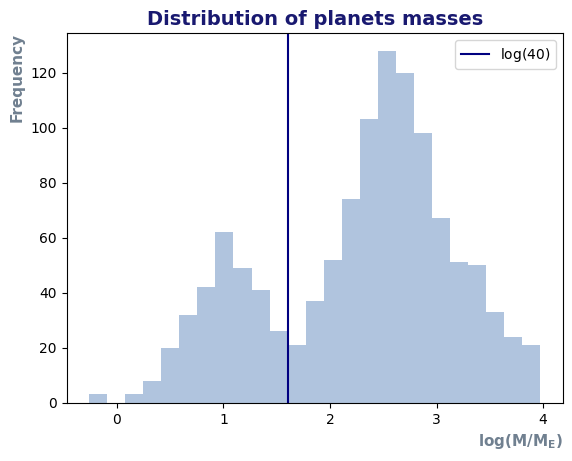

In [10]:
#Create histogram of planets masses and mass_sini
plt.figure()

#Plot the histogram
plt.hist(df['log_mass_def'], bins=25, color='lightsteelblue')

#Plot a vertical line in 40M_E
plt.axvline(x = np.log10(40), color = 'navy', label=r'$\log( 40)$')
plt.legend()

plt.title('Distribution of planets masses', fontweight='bold', fontsize=14, color='midnightblue')
plt.xlabel(r'log(M/$\mathbf{M_E)}$', loc='right', fontweight='bold', fontsize=11, color='slategrey')
plt.ylabel('Frequency', loc='top', fontweight='bold', fontsize=11, color='slategrey');

### Data splittinig based on mass distribution

In [11]:
#Data splitting in planets with masses above and under 40M_E 
l_df = df[df['mass_def']<=40].reset_index(drop=True)
h_df = df[df['mass_def']>40].reset_index(drop=True)


#Extract some columns data in shape of arrays. This will be used in sections 
#Bootstrap and Montecarlo

#Light planets
l_x = l_df['[Fe/H]'].values
l_ex = l_df['e[Fe/H]'].values

l_y = l_df['log_mass_def'].values
l_ey1 = l_df['log_mass_def_error_max'].values
l_ey2 = l_df['log_mass_def_error_min'].values
l_ey = l_df['log_mass_error'].values

l_fmass = l_df['mass_flag'].values


#Heavy planets
h_x = h_df['[Fe/H]'].values
h_ex = h_df['e[Fe/H]'].values

h_y = h_df['log_mass_def'].values
h_ey1 = h_df['log_mass_def_error_max'].values
h_ey2 = h_df['log_mass_def_error_min'].values
h_ey = h_df['log_mass_error']

h_fmass = h_df['mass_flag'].values

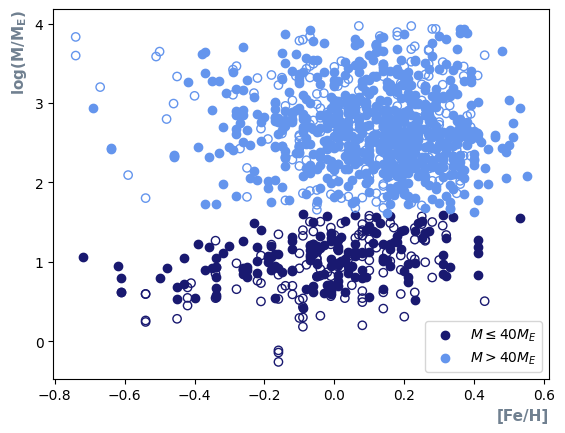

In [12]:
#Plot planet mass- star metalicity diagram, where filled dots represent small 
#mass errors and non filled big errors
plt.figure()

#Light planets
plt.scatter(x=l_df.loc[l_df['log_mass_error'] <= 0.2/np.log(10), '[Fe/H]'], y=l_df.loc[l_df['log_mass_error'] <= 0.2/np.log(10), 'log_mass_def'], color = 'midnightblue', label= r'$M \leq 40M_E$')
plt.scatter(x=l_df.loc[l_df['log_mass_error'] > 0.2/np.log(10), '[Fe/H]'], y=l_df.loc[l_df['log_mass_error'] > 0.2/np.log(10), 'log_mass_def'], edgecolors='midnightblue', facecolors='none')


#Heavy planets
plt.scatter(x=h_df.loc[h_df['log_mass_error'] <= 0.2/np.log(10), '[Fe/H]'], y=h_df.loc[h_df['log_mass_error'] <= 0.2/np.log(10), 'log_mass_def'], color = 'cornflowerblue', label= r'$M > 40M_E$')
plt.scatter(x=h_df.loc[h_df['log_mass_error'] > 0.2/np.log(10), '[Fe/H]'], y=h_df.loc[h_df['log_mass_error'] > 0.2/np.log(10), 'log_mass_def'], edgecolors='cornflowerblue', facecolors='none')

plt.legend()
plt.ylabel(r'log(M/$\mathbf{M_E)}$', loc='top', fontweight='bold', fontsize=11, color='slategrey')
plt.xlabel('[Fe/H]', loc='right', fontweight='bold', fontsize=11, color='slategrey');

plt.show()

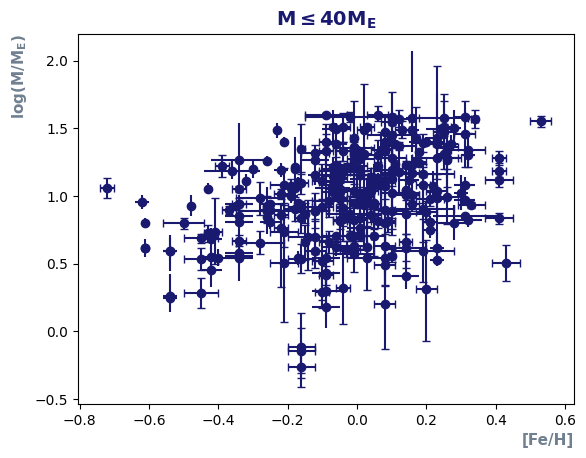

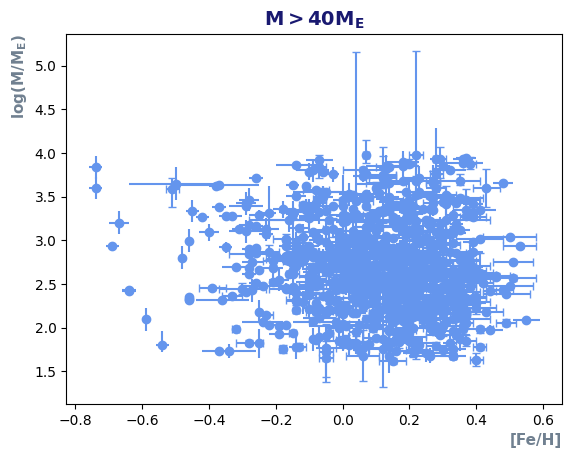

In [13]:
#Plot planet mass- star metalicity diagram in diferent figures for heavy and 
#light planets

#Light
plt.figure()
plt.scatter(l_df['[Fe/H]'], l_df['log_mass_def'], color='midnightblue')
plt.errorbar(x=l_df.loc[l_df['mass_flag'] == 0,'[Fe/H]'], y=l_df.loc[l_df['mass_flag'] == 0,'log_mass_def'], fmt=' ', yerr = (l_df.loc[l_df['mass_flag'] == 0,'log_mass_def_error_min'], l_df.loc[l_df['mass_flag'] == 0,'log_mass_def_error_max']), xerr = l_df.loc[l_df['mass_flag'] == 0,'e[Fe/H]'], ecolor='midnightblue')
plt.errorbar(x=l_df.loc[l_df['mass_flag'] == 1,'[Fe/H]'], y=l_df.loc[l_df['mass_flag'] == 1,'log_mass_def'], fmt=' ', yerr = (l_df.loc[l_df['mass_flag'] == 1,'log_mass_def_error_min'], l_df.loc[l_df['mass_flag'] == 1,'log_mass_def_error_max']), xerr = l_df.loc[l_df['mass_flag'] == 1,'e[Fe/H]'], capsize = 3, ecolor='midnightblue')
plt.title(r'$\mathbf{M \leq 40M_E}$', fontweight='bold', fontsize=14, color='midnightblue')
plt.ylabel(r'log(M/$\mathbf{M_E)}$', loc='top', fontweight='bold', fontsize=11, color='slategrey')
plt.xlabel('[Fe/H]', loc='right', fontweight='bold', fontsize=11, color='slategrey');


#Heavy
plt.figure()
plt.scatter(h_df['[Fe/H]'], h_df['log_mass_def'], color='cornflowerblue')
plt.errorbar(x=h_df.loc[h_df['mass_flag'] == 0,'[Fe/H]'], y=h_df.loc[h_df['mass_flag'] == 0,'log_mass_def'], fmt=' ', yerr = (h_df.loc[h_df['mass_flag'] == 0,'log_mass_def_error_min'], h_df.loc[h_df['mass_flag'] == 0,'log_mass_def_error_max']), xerr = h_df.loc[h_df['mass_flag'] == 0,'e[Fe/H]'], ecolor='cornflowerblue')
plt.errorbar(x=h_df.loc[h_df['mass_flag'] == 1,'[Fe/H]'], y=h_df.loc[h_df['mass_flag'] == 1,'log_mass_def'], fmt=' ', yerr = (h_df.loc[h_df['mass_flag'] == 1,'log_mass_def_error_min'], h_df.loc[h_df['mass_flag'] == 1,'log_mass_def_error_max']), xerr = h_df.loc[h_df['mass_flag'] == 1,'e[Fe/H]'], capsize = 3, ecolor='cornflowerblue')
plt.title(r'$\mathbf{M > 40M_E}$', fontweight='bold', fontsize=14, color='midnightblue')
plt.ylabel(r'log(M/$\mathbf{M_E)}$', loc='top', fontweight='bold', fontsize=11, color='slategrey')
plt.xlabel('[Fe/H]', loc='right', fontweight='bold', fontsize=11, color='slategrey');

# Bootstrap

In [ ]:
def bootstrap_correlation(x, y, ex, ey1, ey2, fmass, mass_ind):
  #Spearman correlation coefficient directly on our data. No simulation yet
  rs0, _ = spearmanr(x, y)
  print('Initial Spearman correlation:', rs0)

  np.random.seed(12345)
  nsimul = 100000 #define the number of simulations
  rs = np.zeros(nsimul) #initialize a vector to save the results of each simulation


  npoints = len(x) #length of the data
  xsim = np.zeros(npoints) #initialize the sample of each simulation
  ysim = np.zeros(npoints) 

  for i in range(nsimul): #repeat the simulation nsimul times
      points = np.random.choice(range(npoints), npoints) #obtain npoints random index with replacement
      xb = x[points] #select those rows in all variables
      exb = ex[points]
      yb = y[points]
      eyb1 = ey1[points]
      eyb2 = ey2[points]
      fmassb = fmass[points]
      
      for j in range(npoints):
          xsim[j] = xb[j] + np.random.normal(0, exb[j], 1) #move x in its error
          if random.uniform(0, 1) > 0.5: #Randomly choose if the upper or lower error on y is used with the same probability
              ymed = yb[j] + abs(np.random.normal(0, eyb1[j], 1)) #if upper error is used, add an absolute value in its upper error
          else:
              ymed = yb[j] - abs(np.random.normal(0, eyb2[j], 1)) #if lower error is used, substract and absolute value in its lower error
              
          if fmassb[j]==1: #if mass informed, do nothing
              ysim[j] = ymed
          else: #if only mass_sini informed, choose a randoom angle between 0 and pi/2 with the same probability and calculate mass
              sini = np.sin(random.uniform(0, np.pi/2))
              ysim[j] = ymed/sini
      
      rs[i], _ = spearmanr(xsim, ysim) #calculate spearman correlation coefficient for simulated data

  corr_mean = np.mean(rs)
  print('Mean Spearman correlation', corr_mean) #calculate the mean of all correlation coefficients obtained
  print('Standard deviation', np.std(rs)) #calculate the standard deviation of all correlation coefficients obtained

  #Plot a histogram of all correlation coefficients obtained
  plt.hist(rs, bins=100, color='lightsteelblue')
  plt.xlabel("r (Spearman)", loc='right', fontweight='bold', fontsize=11, color='slategrey')
  plt.ylabel('Frequency', loc='top', fontweight='bold', fontsize=11, color='slategrey')

  #Plot a vertical line in rs0
  #plt.xticks(ticks = [rs0], labels = [r'$r_0$'], color='navy')
  plt.axvline(x = rs0, color = 'navy', label=r'$r_0$')
  plt.legend(loc='best')
  
  if mass_ind == 'light':
    plt.title(r'$\mathbf{M \leq 40M_E}$', fontweight='bold', fontsize=14, color='midnightblue')
  if mass_ind == 'heavy':
    plt.title(r'$\mathbf{M > 40M_E}$', fontweight='bold', fontsize=14, color='midnightblue')

  plt.show()
  print('Number of negative correlations obtained:', sum(rs <= 0)) #number of negative correlation coeffients obtained
  print('Number of positive correlations obtained:',sum(rs >= 0)) #number of positive correlation coeffients obtained

  if corr_mean>0: #for positive correlation
    print('one-tailed p-value', sum(rs <= 0)/nsimul) #fraction of negative correlation coeffients obtained(1-tailed p-value)
    print('two-tailed p-value', 2 * sum(rs <= 0)/nsimul) #(2-tailed p-value)
  
  else: #for negative correlation
    print('one-tailed p-value', sum(rs >= 0)/nsimul) #fraction of positive correlation coeffients obtained(1-tailed p-value)
    print('two-tailed p-value', 2 * sum(rs >= 0)/nsimul) #(2-tailed p-value)

Initial Spearman correlation: 0.3636549673272529
Mean Spearman correlation 0.203991779696555
Standard deviation 0.0583129094148927


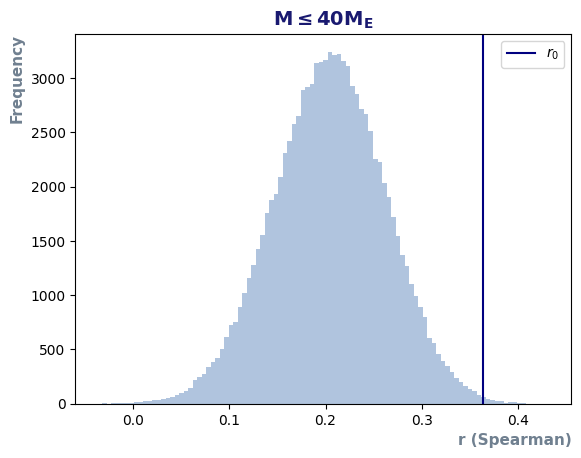

Number of negative correlations obtained: 34
Number of positive correlations obtained: 99966
one-tailed p-value 0.00034
two-tailed p-value 0.00068


In [ ]:
#Light planets
bootstrap_correlation(l_x, l_y, l_ex, l_ey1, l_ey2, l_fmass, 'light')

Initial Spearman correlation: -0.09107183273364745
Mean Spearman correlation -0.12518206590797776
Standard deviation 0.03328603972169726


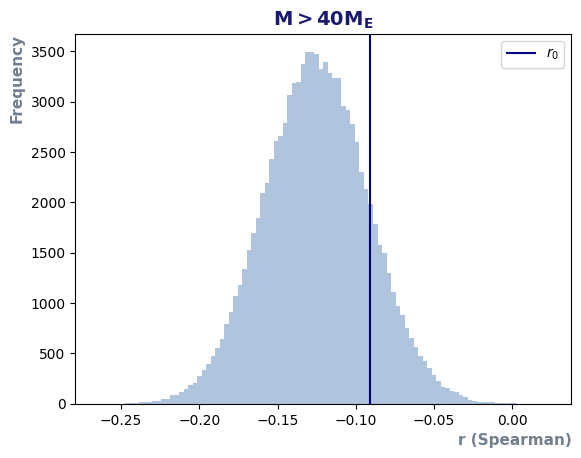

Number of negative correlations obtained: 99989
Number of positive correlations obtained: 11
one-tailed p-value 0.00011
two-tailed p-value 0.00022


In [ ]:
#Heavy planets
bootstrap_correlation(h_x, h_y, h_ex, h_ey1, h_ey2, h_fmass, 'heavy')

# Montecarlo

### Plot code

In [14]:
#Function to plot all results in this section except the ones in code 2
def montecarlo_plot(x, y, rho, mockx, mass_ind, first=False):
  N = len(x)
  rho_mean = np.mean(rho)
  rho_desv = np.std(rho)
  nsimul = len(rho[0])
  print('mean', rho_mean)
  print('standard deviation', rho_desv)

  if rho_mean>0:
    print('one-tailed p-value', sum(rho[0] <= 0)/nsimul) #fraction of negative correlation coeffients obtained(1-tailed p-value)
    print('two-tailed p-value', 2 * sum(rho[0] <= 0)/nsimul) #(2-tailed p-value)
  
  else:
    print('one-tailed p-value', sum(rho[0] >= 0)/nsimul) #fraction of positive correlation coeffients obtained(1-tailed p-value)
    print('two-tailed p-value', 2 * sum(rho[0] >= 0)/nsimul) #(2-taield p-value)

  #Plot a histogram of all correlation coefficients obtained
  plt.figure()
  n, bins, patches = plt.hist(rho[0], bins=50, color='lightsteelblue')
  plt.xlabel(r"$\mathbf{\rho}$", loc='right', fontweight='bold', fontsize=11, color='slategrey')
  plt.ylabel('Frequency', loc='top', fontweight='bold', fontsize=11, color='slategrey')

  #Plot a vertical line with mean correlation coefficient
  plt.axvline(x = rho_mean, color = 'navy', label=r'mean ='+str("{:.4f}".format(rho_mean)))

  if first:
    #Plot the theoretical graph
    r = sps.pearsonr(x,y)[0]
    rho_theory = np.linspace(rho_mean-0.25, rho_mean+0.25,100)
    theory = ((1-rho_theory**2)**((N-1)/2)/(1-rho_theory*r)**(N-3/2))*(1+(1+r*rho_theory)/(8*(N-1/2)))

    #It is not normalised. To normalise it it is necesary to divide by the max
    #value of theory and multiply by frecuency of the middle bin in the histogram

    # Find the frequency of the middle bin
    num_bins = len(bins)
    median_bin_index = num_bins // 2
    frequency = n[median_bin_index]

    theory = theory/(max(theory)/frequency)
    plt.plot(rho_theory,theory, color='slateblue', label='Theory')
  
  plt.legend(loc='best')
  


  if mass_ind == 'light':
    plt.title(r'$\mathbf{M \leq 40M_E}$', fontweight='bold', fontsize=14, color='midnightblue')
  if mass_ind == 'heavy':
    plt.title(r'$\mathbf{M > 40M_E}$', fontweight='bold', fontsize=14, color='midnightblue')
  
  plt.show()


  #Plot confidence ellipses

  # Calculate the mean and covariance matrix
  mean = np.array([np.mean(x), np.mean(y)])
  cov = np.cov(np.vstack((x, y)))

  # Calculate the eigenvalues and eigenvectors of the covariance matrix
  eigenvals, eigenvecs = np.linalg.eig(cov)

  # Get the angle of rotation for the ellipses
  theta = np.degrees(np.arctan2(*eigenvecs[::-1,0]))

  # Create the figure and axis objects
  fig, ax = plt.subplots()

  # Plot the data points
  ax.scatter(mockx[0],mockx[1], color='lightsteelblue', label='Simulated data', marker='.')
  ax.scatter(x, y, color='cornflowerblue', label='Real data',  marker='.')

  # Plot the 95% confidence ellipse
  conf_95 = sps.chi2.ppf(0.95, df=2)
  width_95, height_95 = 2 * np.sqrt(conf_95 * eigenvals)
  ellipse_95 = Ellipse(xy=mean, width=width_95, height=height_95, angle=theta, edgecolor='midnightblue', facecolor='none', linewidth=2.5, label='95%')
  ax.add_patch(ellipse_95)

  # Plot the 67% confidence ellipse
  conf_67 = sps.chi2.ppf(0.67, df=2)
  width_67, height_67 = 2 * np.sqrt(conf_67 * eigenvals)
  ellipse_67 = Ellipse(xy=mean, width=width_67, height=height_67, angle=theta, edgecolor='steelblue', facecolor='none', linewidth=2.5, label='67%')
  ax.add_patch(ellipse_67)

  ax.set_xlabel('[Fe/H]', loc='right', fontweight='bold', fontsize=11, color='slategrey')
  ax.set_ylabel(r'log(M/$\mathbf{M_E)}$', loc='top', fontweight='bold', fontsize=11, color='slategrey')

  ax.legend()

  if mass_ind == 'light':
    ax.set_title(r'$\mathbf{M \leq 40M_E}$', fontweight='bold', fontsize=14, color='midnightblue')
  if mass_ind == 'heavy':
    ax.set_title(r'$\mathbf{M > 40M_E}$', fontweight='bold', fontsize=14, color='midnightblue')


  # Show the plot
  plt.show()

### Code 1: no errors

In [17]:
def mcmc_no_errors(x,y, n_chains, n_samples):
  stan_code = """
  data {
  int<lower=1> N;
  vector[2] x[N];
  }
  parameters {
  vector[2] mu;
  real<lower=0> sigma[2];
  real<lower=-1, upper=1> rho;
  }
  transformed parameters {
  cov_matrix[2] cov = 
  [[sigma[1]^ 2, sigma[1]*sigma[2]*rho],
  [sigma[1]*sigma[2]* rho, sigma[2]^2]];
  }
  model {
  x ~ multi_normal(mu, cov);
  sigma ~ cauchy(0., 10.);
  mu ~ normal(0., 100.);
  }
  generated quantities {
  vector[2] mockx;
  mockx = multi_normal_rng(mu, cov);
  }
  """

  # get data
  N = len(x)
  x_sim = np.column_stack((x, y))

  # compile the model
  posterior = stan.build(program_code=stan_code, data={"N": N, "x": x_sim});

  
  # fit the model
  fit = posterior.sample(num_chains=n_chains, num_samples=n_samples);

  # extract the posterior samples
  mu = fit['mu']
  sigma = fit['sigma']
  rho = fit['rho']
  mockx = fit['mockx']

  return mu, sigma, rho, mockx

#### Light planets

In [ ]:
l_mu1, l_sigma1, l_rho1, l_mockx1 = mcmc_no_errors(l_x, l_y, 4, 10000)

mean 0.3589245194589662
standard deviation 0.05188163921839508
one-tailed p-value 0.0
two-tailed p-value 0.0


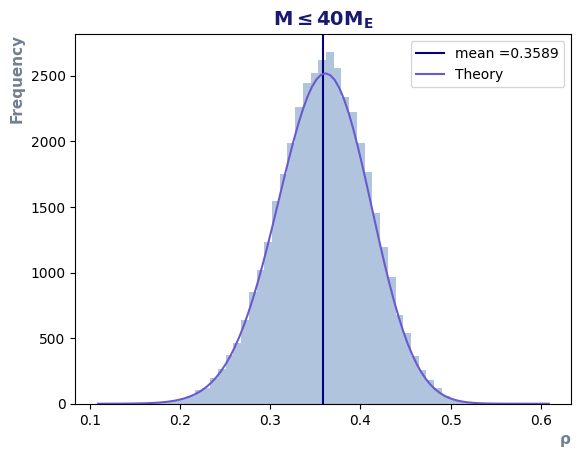

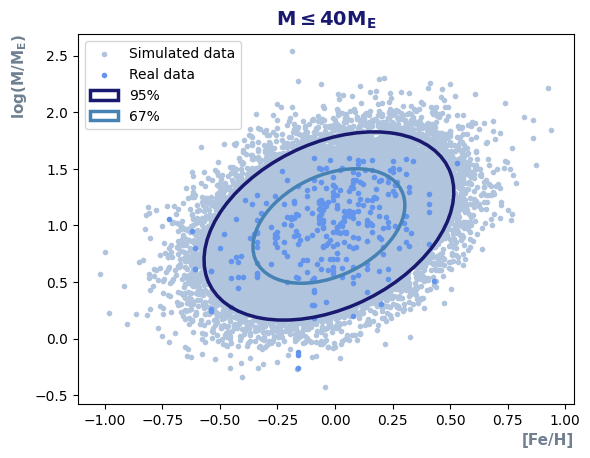

In [24]:
montecarlo_plot(l_x, l_y, l_rho1, l_mockx1, 'light', first=True) #tiene que dar 0.36

#### Heavy planets

In [ ]:
h_mu1, h_sigma1, h_rho1, h_mockx1 = mcmc_no_errors(h_x, h_y, 4, 10000)

mean -0.08421445849011049
standard deviation 0.0338779086732073
one-tailed p-value 0.0061
two-tailed p-value 0.0122


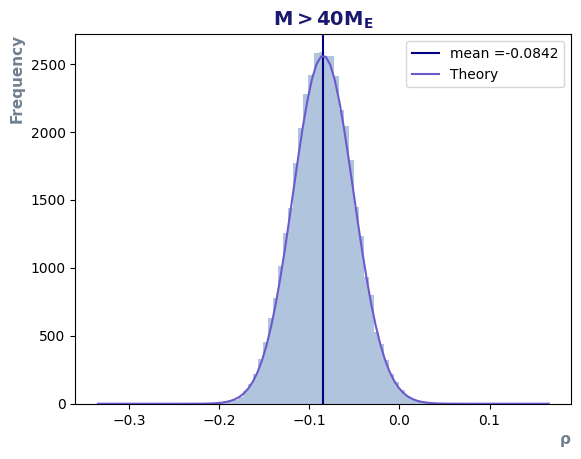

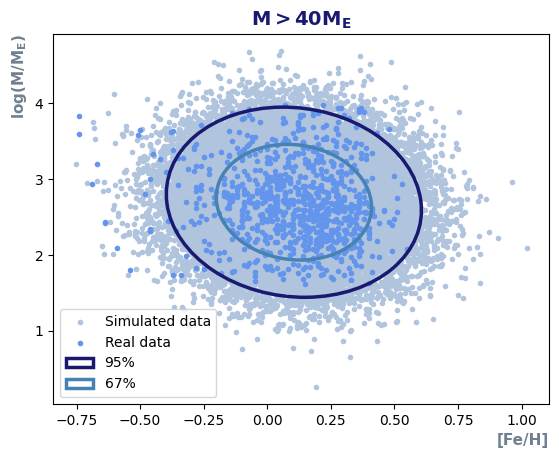

In [25]:
montecarlo_plot(h_x, h_y, h_rho1, h_mockx1, 'heavy', first=True) #tiene que dar -0.09

### Code 2: robust correlation

In [14]:
def mcmc_robust(x,y, n_chains, n_samples):

  stan_code = """
  data {
  int<lower=1> N;
  vector[2] x[N];
  }
  parameters {
  vector[2] mu;
  real<lower=0> sigma[2];
  real<lower=-1, upper=1> rho;
  real<lower=1> nu;
  }
  transformed parameters {
  cov_matrix[2] cov = 
  [[sigma[1]^ 2, sigma[1]*sigma[2]*rho],
  [sigma[1]*sigma[2]* rho, sigma[2]^2]];
  }
  model {
  x ~ multi_student_t(nu, mu, cov);
  sigma ~ cauchy(0., 10.);
  mu ~ normal(0., 100.);
  nu ~ gamma(2, 0.1);
  }
  generated quantities {
  vector[2] mockx;
  mockx = multi_student_t_rng(nu, mu, cov);
  }
  """
  

  # get data
  N = len(x)
  x_sim = np.column_stack((x, y))

  # compile the model
  posterior = stan.build(program_code=stan_code, data={"N": N, "x": x_sim});

  
  # fit the model
  fit = posterior.sample(num_chains=n_chains, num_samples=n_samples);

  # extract the posterior samples
  mu = fit['mu']
  sigma = fit['sigma']
  rho = fit['rho']
  nu = fit['nu']

  return mu, sigma, rho, nu

In [20]:
def plot_robust(rho, nu, mass_ind):
  nu_mean = np.mean(nu)
  nu_dev = np.std(nu)
  print('Mean degrees of freedom', nu_mean)
  print('Standard deviation', nu_dev)

  rho_mean = np.mean(rho)
  rho_dev = np.std(rho)
  nsimul = len(rho[0])
  print('Mean correlation', rho_mean)
  print('Standard deviation', rho_dev)

  if rho_mean>0:
    print('one-tailed p-value', sum(rho[0] <= 0)/nsimul) #fraction of negative correlation coeffients obtained(1-tailed p-value)
    print('two-tailed p-value', 2 * sum(rho[0] <= 0)/nsimul) #(2-tailed p-value)
  
  else:
    print('one-tailed p-value', sum(rho[0] >= 0)/nsimul) #fraction of positive correlation coeffients obtained(1-tailed p-value)
    print('two-tailed p-value', 2 * sum(rho[0] >= 0)/nsimul) #(2-taield p-value)


  #Plot a histogram of all degrees of freedom obtained
  plt.hist(np.log10(nu[0]), bins=50, color='lightsteelblue')
  plt.xlabel(r"log $\mathbf{\nu}$", loc='right', fontweight='bold', fontsize=11, color='slategrey')
  plt.ylabel('Frequency', loc='top', fontweight='bold', fontsize=11, color='slategrey')

  #Plot a vertical line in the mean degree of freedom
  plt.axvline(x = np.log10(nu_mean), color = 'navy', label=r'$\nu_{mean}$ ='+str("{:.4f}".format(nu_mean)))

  #Plot a vertical line in 30 degrees of freedom
  plt.axvline(x = np.log10(30), color = 'slateblue', label=r'$\nu = 30$')
  plt.legend(loc='best')


  if mass_ind == 'light':
    plt.title(r'$\mathbf{M \leq 40M_E}$', fontweight='bold', fontsize=14, color='midnightblue')
  if mass_ind == 'heavy':
    plt.title(r'$\mathbf{M > 40M_E}$', fontweight='bold', fontsize=14, color='midnightblue')

#### Light planets

In [ ]:
l_mu2, l_sigma2, l_rho2, l_nu2 = mcmc_robust(l_x, l_y, 4, 10000)

Mean degrees of freedom 26.902113666508086
Standard deviation 12.915747555036194
Mean correlation 0.36278254780661684
Standard deviation 0.05280317604650861
one-tailed p-value 0.0
two-tailed p-value 0.0


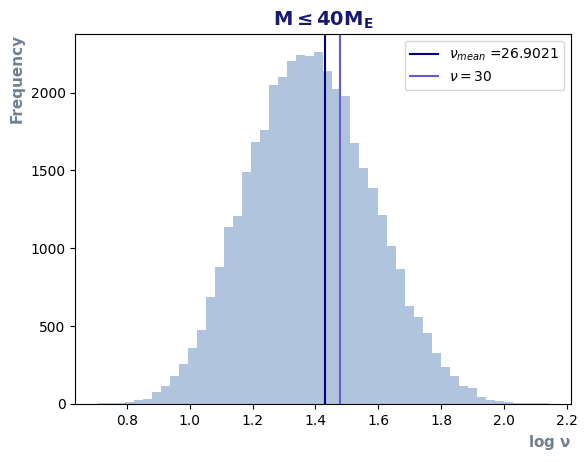

In [21]:
plot_robust(l_rho2, l_nu2, 'light')

#### Heavy planets

In [ ]:
h_mu2, h_sigma2, h_rho2, h_nu2 =  mcmc_robust(h_x, h_y, 4, 10000)

Mean degrees of freedom 24.206215591689027
Standard deviation 9.167999206327181
Mean correlation -0.08663197003084422
Standard deviation 0.03472266698889883
one-tailed p-value 0.0068
two-tailed p-value 0.0136


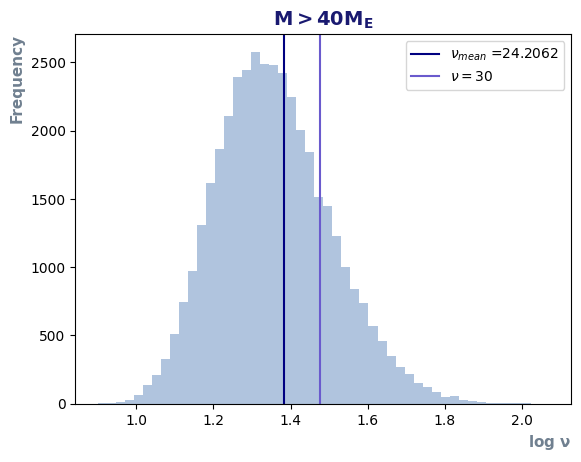

In [23]:
plot_robust(h_rho2, h_nu2, 'heavy')

### Code 3: errors

In [51]:
def mcmc_errors(x, y, ex, ey, n_chains, n_samples):
  stan_code = """
  data {
  int<lower=1> N;
  matrix[N, 2] x;
  matrix[N, 2] errx;
  }
  parameters {
  vector[2] mu;
  real<lower=0> sigma[2];
  real<lower=-1, upper=1> rho;
  matrix[N, 2] xreal;
  }
  transformed parameters {
  cov_matrix[2] cov = 
  [[sigma[1]^ 2, sigma[1]*sigma[2]*rho],
  [sigma[1]*sigma[2]* rho, sigma[2]^2]];
  }
  model {
  for (i in 1:N){
    x[i,1] ~ normal(xreal[i,1], errx[i,1]);
    x[i,2] ~ normal(xreal[i,2], errx[i,2]);
  }
    
  for (i in 1:N)
    xreal[i] ~ multi_normal(mu, cov);
  sigma ~ cauchy(0., 10.);
  mu ~ normal(0., 100.);
  }
  generated quantities {
  vector[2] mockx;
  mockx = multi_normal_rng(mu, cov);
  } 
  """


  # get data
  N = len(x)
  x_sim = np.column_stack((x, y))
  err_x_sim = np.column_stack((ex,ey))

  # compile the model
  posterior = stan.build(program_code=stan_code, data={'N': N, 'x': x_sim, 'errx': err_x_sim});

  
  # fit the model
  fit = posterior.sample(num_chains=n_chains, num_samples=n_samples);

  # extract the posterior samples
  mu = fit['mu']
  sigma = fit['sigma']
  rho = fit['rho']
  mockx = fit['mockx']

  return mu, sigma, rho, mockx

#### Light planets

In [ ]:
l_mu3, l_sigma3, l_rho3, l_mockx3 = mcmc_errors(l_x, l_y, l_ex, l_ey, 4, 10000)

mean 0.39644923406079136
standard deviation 0.054265341986277346
one-tailed p-value 0.0
two-tailed p-value 0.0


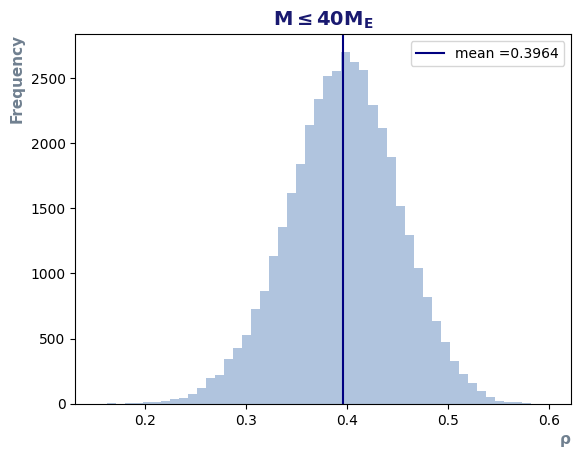

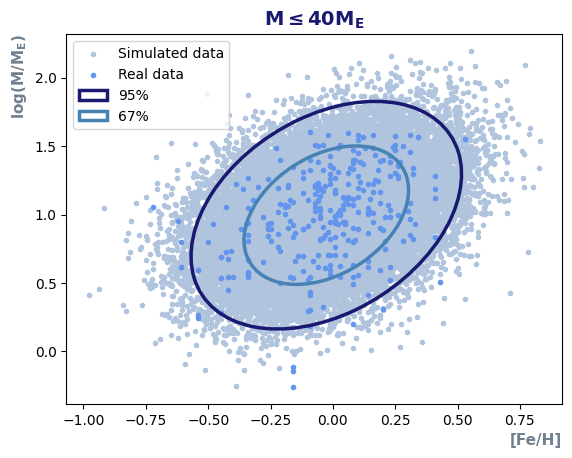

In [53]:
montecarlo_plot(l_x, l_y, l_rho3, l_mockx3, 'light') #tiene que dar 0.36

#### Heavy planets

In [ ]:
h_mu3, h_sigma3, h_rho3, h_mockx3 = mcmc_errors(h_x, h_y, h_ex, h_ey, 4, 5000)

mean -0.08803961935128768
standard deviation 0.0345953697439067
one-tailed p-value 0.00535
two-tailed p-value 0.0107


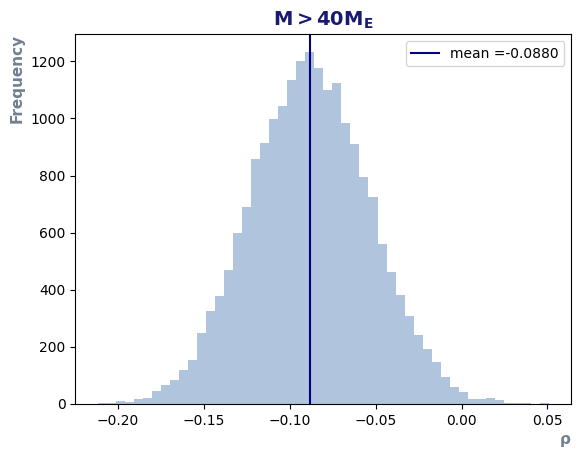

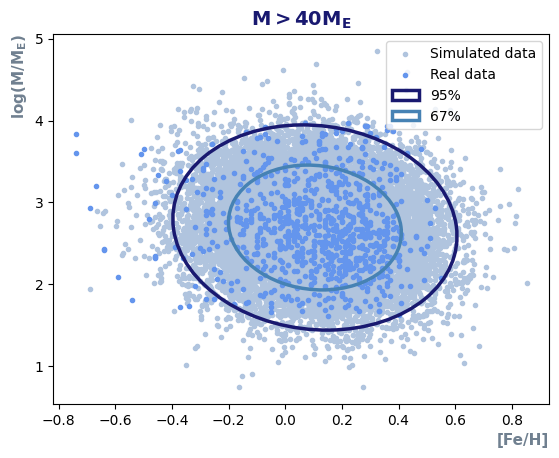

In [55]:
montecarlo_plot(h_x, h_y, h_rho3, h_mockx3, 'heavy')

### Code 4: errors and boundaries

In [15]:
def mcmc_sin(x, y, ex, ey, mass_flag, n_chains, n_samples):
  stan_code = """
  data {
  int<lower=1> N1;
  int<lower=1> N2;
  matrix[N1, 2] x;
  matrix[N1, 2] errx;
  matrix[N2, 2] xsin;
  matrix[N2, 2] errxsin;
  }


  parameters {
  vector[2] mu;
  real<lower=0> sigma[2];
  real<lower=-1, upper=1> rho;
  matrix[N1, 2] xreal;
  matrix[N2, 2] xsinreal;
  vector<lower=0, upper=pi()/2>[N2] angle;
  }


  transformed parameters {
  cov_matrix[2] cov = 
  [[sigma[1]^ 2, sigma[1]*sigma[2]*rho],
  [sigma[1]*sigma[2]* rho, sigma[2]^2]];
  }


  model {
  for (i in 1:N1) {
    x[i] ~ normal(xreal[i], errx[i]);
  }
  for (i in 1:N2) {
    xsin[i,1] ~ normal(xsinreal[i,1], errxsin[i,1]);
    xsin[i,2] ~ normal(xsinreal[i,2] * sin(angle[i]), errxsin[i,2]);
  }
  
  for (i in 1:N1)
    xreal[i] ~ multi_normal(mu,cov);
  for (i in 1:N2)
    xsinreal[i] ~ multi_normal(mu, cov);
  sigma ~ cauchy(0., 10.);
  mu ~ normal(0., 100.);
  }

  
  generated quantities {
  vector[2] mockx;
  mockx = multi_normal_rng(mu, cov);
  }
  """


  # get data
  x_mass = np.column_stack((x[mass_flag.astype(bool)], y[mass_flag.astype(bool)]))
  err_x_mass = np.column_stack((ex[mass_flag.astype(bool)],ey[mass_flag.astype(bool)]))
  N1 = len(x_mass)

  x_sin = np.column_stack((x[~mass_flag.astype(bool)], y[~mass_flag.astype(bool)]))
  err_x_sin = np.column_stack((ex[~mass_flag.astype(bool)],ey[~mass_flag.astype(bool)]))
  N2 = len(x_sin)

  # compile the model
  posterior = stan.build(program_code=stan_code, data={'N1': N1, 'N2': N2, 'x': x_mass, 'errx':err_x_mass, 'xsin': x_sin, 'errxsin': err_x_sin});

  
  # fit the model
  fit = posterior.sample(num_chains=n_chains, num_samples=n_samples);

  # extract the posterior samples
  mu = fit['mu']
  sigma = fit['sigma']
  rho = fit['rho']
  mockx = fit['mockx']

  return mu, sigma, rho, mockx

#### Light planets

In [ ]:
l_mu4, l_sigma4, l_rho4, l_mockx4 = mcmc_sin(l_x, l_y, l_ex, l_ey, l_fmass, 4, 2500)

mean 0.35462551287780036
standard deviation 0.06402117451971606
one-tailed p-value 0.0
two-tailed p-value 0.0


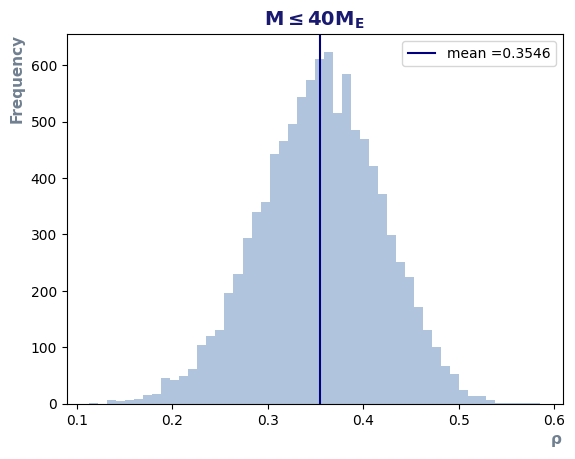

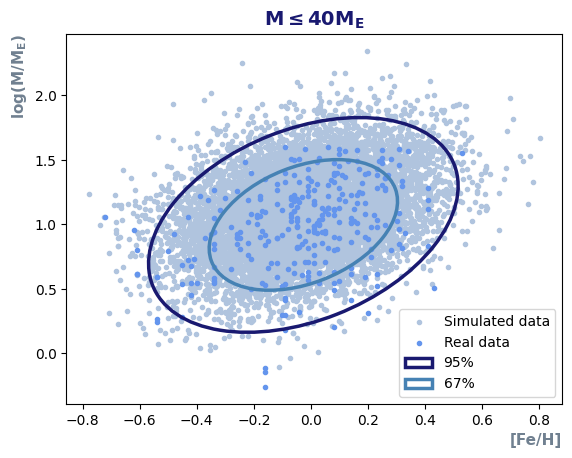

In [58]:
montecarlo_plot(l_x, l_y, l_rho4, l_mockx4, 'light')

#### Heavy planets

In [ ]:
h_mu4, h_sigma4, h_rho4, h_mockx4 = mcmc_sin(h_x, h_y, h_ex, h_ey, h_fmass, 4, 2500)

mean -0.17904095916484203
standard deviation 0.039855031075876075
one-tailed p-value 0.0
two-tailed p-value 0.0


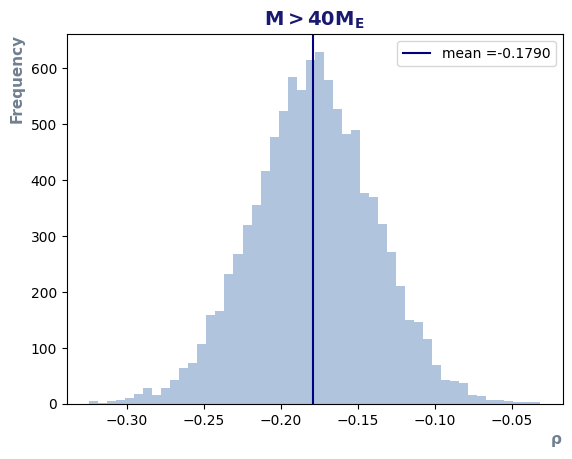

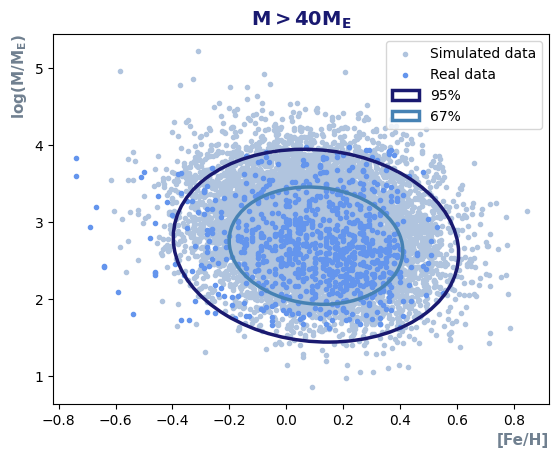

In [17]:
montecarlo_plot(h_x, h_y, h_rho4, h_mockx4, 'heavy')